In [1]:
#Imports

import os
import time
import tqdm
import numpy as np
import qcodes as qc
from qcodes.utils.dataset.doNd import do1d, do2d, dond, plot, LinSweep, LogSweep
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement


from qcodes.dataset import (
    load_or_create_experiment,
    load_by_guid,
    load_by_run_spec,
    initialise_or_create_database_at,
    Measurement,
    DataSetType,
)
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.dataset.plotting import plot_dataset


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\a-davidpoole\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\a-davidpoole\.qcodes\logs\211116-16932-qcodes.log


In [2]:
#Set up local database

testing_db_path = os.path.join(os.getcwd(), 'local.db')
initialise_or_create_database_at(testing_db_path)

In [3]:

# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrumentWithMeasurement('dmm', setter_instr=dac)


In [4]:

# Setting up Measurement
testing_exp = load_or_create_experiment('loop_1', sample_name='no sample')

#Setting up measuremetn without shape
meas = Measurement(name= 'simple meas', exp=testing_exp)
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,dac.ch2))
meas.register_parameter(dmm.v2, setpoints=(dac.ch1,dac.ch2))

#Setting Up measurement with shapes
meas_with_shape = Measurement(exp=testing_exp, name='shape meas')
meas_with_shape.register_parameter(dac.ch1)  # register the first independent parameter
meas_with_shape.register_parameter(dac.ch2)  # register the second independent parameter
meas_with_shape.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone
meas_with_shape.register_parameter(dmm.v2, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone



In [5]:
#Setting up dataset sizes.
size_a = 500
size_b = 200
size_n = 1

In [6]:
#Measurement with context manager with cache
t_a = []

bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas.run() as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): # sweep points over channel 1
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b): # sweep points over channel 2
                dac.ch2(dac2_sweep)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_a.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset

print(sum(t_a)/len(t_a))

2021-11-16 12:48:15,394 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_16932/616408506.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 2. 
0.720519733000016


In [7]:
#Measurement with context manager with shaped cache
meas_with_shape.set_shapes(detect_shape_of_measurement((dmm.v1,dmm.v2), (size_a, size_b)))

bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

t_b = []
for _ in range(size_n):
    with meas_with_shape.run() as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b):
                dac.ch2(dac2_sweep)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_b.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset
print(sum(t_b)/len(t_b))


2021-11-16 12:49:31,643 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_16932/2853598699.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 3. 
0.20882259299995254


In [8]:
#Measurement with context manager without cache
t_c = []
bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas.run(in_memory_cache=False) as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b):
                dac.ch2(dac2_sweep)
                #bar.update(1)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_c.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset

print(sum(t_c)/len(t_c))

2021-11-16 12:49:55,784 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_16932/2863477060.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 4. 
0.12274790000001332


In [9]:
#Measurement with context manager with cache, dataset in memory.
t_d = []
bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas.run(dataset_class=DataSetType.DataSetInMem) as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b): 
                dac.ch2(dac2_sweep)
                #bar.update(1)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_d.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset
print(sum(t_d)/len(t_d))

2021-11-16 12:50:10,342 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_16932/1923311262.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 5. 
0.40481991599998185


In [10]:
#Measurement with context manager with shaped cache and dataset in memory
meas_with_shape.set_shapes(detect_shape_of_measurement((dmm.v1,dmm.v2), (size_a, size_b)))

t_e = []
bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)

for _ in range(size_n):
    with meas_with_shape.run(dataset_class=DataSetType.DataSetInMem) as datasaver:
        for dac1_sweep in np.linspace(-1, 1, size_a): 
            dac.ch1(dac1_sweep)
            t = []
            for dac2_sweep in np.linspace(-1, 1, size_b):
                dac.ch2(dac2_sweep)
                t0 = time.perf_counter()
                datasaver.add_result(
                    (dac.ch1, dac.ch1()),
                    (dac.ch2, dac.ch2()),
                    (dmm.v1, dmm.v1()),
                    (dmm.v2, dmm.v2())
                    )
                t1 = time.perf_counter()
                t.append(t1-t0)
                bar.update(1)
            t_e.append(sum(t)/len(t)*1000)
        dataset2 = datasaver.dataset
print(sum(t_e)/len(t_e))

2021-11-16 12:50:54,303 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 109 ¦ C:\Users\A-DAVI~1\AppData\Local\Temp/ipykernel_16932/1493501015.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm.tqdm_notebook(total=size_a*size_b*size_n)



  0%|          | 0/100000 [00:00<?, ?it/s]

Starting experimental run with id: 6. 
0.20322497200001835


In [11]:
#Measurement with doNd, estimated time by total dataset size
#Bar is not included since this may add a slight delay.
sweep_1 = LinSweep(dac.ch1, -1, 1, size_a)
sweep_2 = LinSweep(dac.ch2, -1, 1, size_b)
t_f = []
for _ in range(size_n):
    t0 = time.perf_counter()
    dond(sweep_1, sweep_2, dmm.v1, dmm.v2, exp=testing_exp) 
    t1 = time.perf_counter()
    t_f.append(t1-t0)
print(sum(t_f)/len(t_f)/size_a/size_b*1000)   

Starting experimental run with id: 7. Using 'qcodes.utils.dataset.doNd.dond'
0.279476989


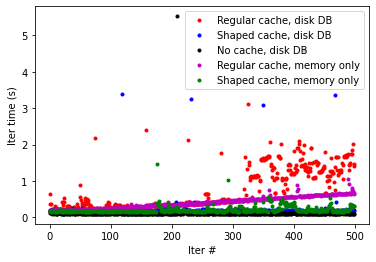

In [12]:
#plotting the measurement context results in a single figure.
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.plot(t_a, '.r', label='Regular cache, disk DB') 
plt.plot(t_b, '.b', label='Shaped cache, disk DB')
plt.plot(t_c, '.k', label='No cache, disk DB')
plt.plot(t_d, '.m', label='Regular cache, memory only')
plt.plot(t_e, '.g', label='Shaped cache, memory only')
#plt.ylim(0,0.01)
plt.ylabel('Iter time (s)') 
plt.xlabel('Iter #') 
plt.legend()
plt.show() 

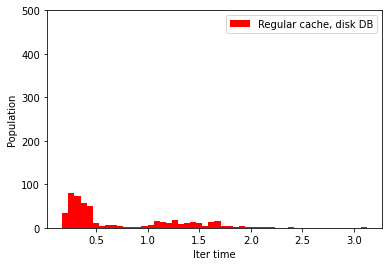

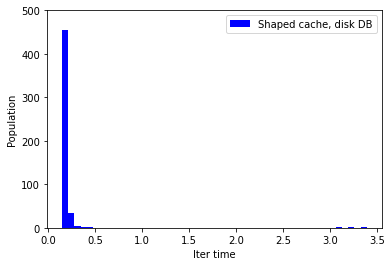

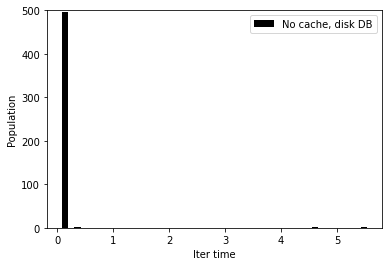

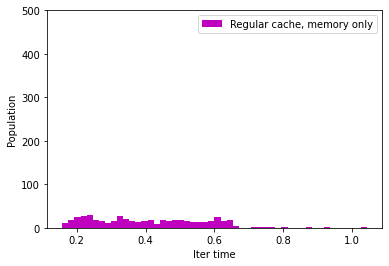

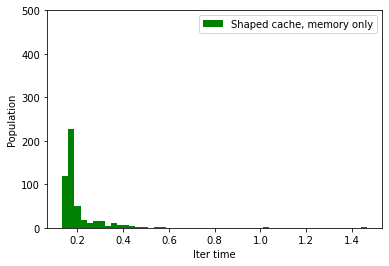

In [13]:
#plotting the measurement context results as a histogram.
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.hist(t_a, 50, facecolor= 'r', label='Regular cache, disk DB') 
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_b, 50, facecolor= 'b', label='Shaped cache, disk DB')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_c, 50, facecolor= 'k', label='No cache, disk DB')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_d, 50, facecolor= 'm', label='Regular cache, memory only')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 
plt.hist(t_e, 50, facecolor= 'g', label='Shaped cache, memory only')
plt.ylabel('Population')
plt.ylim(0, size_a)
plt.xlabel('Iter time') 
plt.legend()
plt.show() 

Intro: Cache performance is critical when working with large datasets 
    obtained from several iterations of the add_results() method. In some
    cases successive expansions of the existing cache result in severe
    slowing of system performance. To this end Jens has added the shaped 
    cache feature, which pre-allocates the memory for caching, avoiding the
    intensive process of cache expansion. To demonstrate and test this new
    feature, we have run 7 test cases to assess cache performance featuring
    contexts without cache, with the default cache, and pre-allocated cache
    enabled. We have also included variants which write to the regular SQLite
    database, or keep all data in memory. Lastly, these are compared to the
    DoNd functions which already pre-allocate cache size based on data shape.

Conclusions: 
    1-  Dynamically allocated cache underperforms in all cases.
    2-  DoNd with and without cache offer equivalent performance.
    3-  SQLite database writes do not hinder performance.

Reference:
1 - Measurement with context manager with cache                              
2 - Measurement with context manager with shaped cache                       
3 - Measurement with context manager without cache                           
4 - Measurement with context manager with cache, dataset in memory.          
5 - Measurement with context manager with shaped cache and dataset in memory.
6 - Measurement with doNd, iteration time estimated from total execution
7 - Measurement with doNd (nocache) iteration time estimated from total execution

Timed function: add_result() (exp 1-5), DoNd() (exp 6-7).
'''
|                        Results		                        |
| n		| exp_1	| exp_2	| exp_3	| exp_4	| exp_5	| exp_6*| exp_7*|
| iter	| ----------- avg ms iter^-1 -------------------------- |
| 1		| 0.934	| 0.879	| 0.321	| 0.377	| 0.473	| 60.51 | 57.48 |
| 2		| 0.413	| 0.478	| 0.256	| 0.496	| 0.471	| 45.12 | 29.89 |
| 5		| 0.418	| 0.291	| 0.295	| 0.324	| 0.488	| 16.85 | 12.11 |
| 10	| 0.452	| 0.324	| 0.283	| 0.491	| 0.363	| 7.071 | 7.071 |
| 50	| 0.311	| 0.527	| 0.309	| 0.322	| 0.341	| 2.442	| 1.532	|
| 100	| 0.288	| 0.326	| 0.127	| 0.317	| 0.346	| 1.457 | 0.753 |
| 1000	| 0.257	| 0.217	| 0.125	| 0.209	| 0.214	| 0.319 | 0.269 |
| 10000	| 0.289	| 0.267	| 0.141	| 0.227	| 0.219	| 0.238 | 0.238 |
| 20000	| 0.287	| 0.252	| 0.126	| 0.262	| 0.217	| 0.247 | 0.227 |
| 50000	| 0.342	| 0.305	| 0.142	| 0.297	| 0.230	| 0.234 | 0.234 |
| 100000| 0.591	| 0.251	| 0.180	| 0.589	| 0.293	| 0.253 | 0.228 |
| 200000| 2.042	| 0.257	| 0.180	| 1.863	| 0.203	| 0.268	| 0.229	|
'''